<!-- dom:TITLE: Demo - Integration of functions -->
# Demo - Integration of functions
<!-- dom:AUTHOR: Mikael Mortensen Email:mikaem@math.uio.no at Department of Mathematics, University of Oslo. -->
<!-- Author: -->  
**Mikael Mortensen** (email: `mikaem@math.uio.no`), Department of Mathematics, University of Oslo.

Date: **Aug 18, 2020**

Copyright 2020, Mikael Mortensen. Released under CC Attribution 4.0 license

**Summary.** This is a demonstration of how the Python module [shenfun](https://github.com/spectralDNS/shenfun) can be used to
integrate over 1D curves and 2D surfaces in 3D space.
We make use of
curvilinear coordinates, and reproduce some integrals
performed by Behnam Hashemi with [Chebfun](http://www.chebfun.org/examples/approx3/SurfaceIntegral3D.html).

**Notice.**

For all the examples below we could just as well
use Legendre polynomials instead of Chebyshev.
Just replace 'C' with 'L' when creating function spaces.
The accuracy ought to be similar.












## The inner product

A lesser known fact about [shenfun](https://github.com/spectralDNS/shenfun) is
that it can be used to perform regular, unweighted, integrals with
spectral accuracy. With the newly added curvilinear coordinates
feature, we can now also integrate over highly complex lines and surfaces
embedded in a higher dimensional space.

To integrate over a domain in shenfun we use the
[inner](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.inner.inner)
function, with a constant test function. The `inner`
function in shenfun is defined as an integral over the
entire domain $\Omega$ in question

$$
(u, v)_w = \int_{\Omega} u \overline{v} w d\Omega,
$$

for trial function $u$, test function $v$ and weight $w$.
Also, $\overline{v}$ represents the complex conjugate of $v$, in case
we are working with complex functions (like Fourier exponentials).

The functions and weights take on different form, but if
the test function $v$ is chosen to be a constant, e.g., $v=1$,
then the weight is also constant, $w=1$, and the inner product becomes
an unweighted integral of $u$ over the domain

$$
(u, 1)_w = \int_{\Omega} u d\Omega
$$

### Curve integrals

For example, if we create some function space on the line from
0 to 1, then we can get the length of this domain using `inner`

In [1]:
from shenfun import *
B = FunctionSpace(10, 'C', domain=(0, 1))
u = Array(B, val=1)
length = inner(u, 1)
print('Length of domain =', length)

Length of domain = 1.0000000000000002


Since this function space `B` is Cartesian the computed
length is simply the domain length.
Not very impressive, but the same goes for multidimensional
tensor product domains

In [2]:
F = FunctionSpace(10, 'F', domain=(0, 2*np.pi))
T = TensorProductSpace(comm, (B, F))
area = inner(1, Array(T, val=1))
print('Area of domain =', area)

Area of domain = 6.283185307179587


Still not very impressive, but moving to curvilinear coordinates
it all starts to become more interesting. Lets
look at a spiral $C$ embedded in $\mathbb{R}^3$, parametrized
by one single parameter $t$

$$
\begin{align*}
x(t) &= \sin 2t \\ 
y(t) &= \cos 2t \\ 
z(t) &= \frac{t}{2} \\ 
0 \le & t \le 2\pi
\end{align*}
$$

What is the length of this spiral? The spiral can be
seen as the red curve in the figure a few cells below.

The integral over the parametrized curve $C$ can
be written as

$$
\int_C ds = \int_{t=0}^{2\pi} \sqrt{\left(\frac{d x}{d t}\right)^2 + \left(\frac{d y}{d t}\right)^2 + \left(\frac{d z}{d t}\right)^2} dt.
$$

We can find this integral easily using shenfun. Create
a function space in curvilinear coordinates, providing
the position vector $\mathbf{r} = x(t)\mathbf{i} + y(t) \mathbf{j} + z(t) \mathbf{k}$
as input

In [3]:
import sympy as sp
from shenfun import *
t = sp.Symbol('x', real=True, positive=True)
rv = (sp.sin(2*t), sp.cos(2*t), 0.5*t)
C = FunctionSpace(100, 'C', domain=(0, 2*np.pi), coordinates=((t,), rv))

Then compute the arclength using `inner`

In [4]:
length = inner(1, Array(C, val=1))
print('Length of spiral =', length)

Length of spiral = 12.95311834341519


The arclength is found to be slightly longer than $4 \pi$. Looking at the
spiral below, the result looks reasonable.

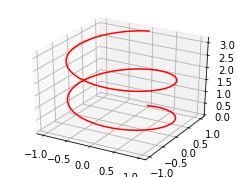

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4, 3))
X = C.curvilinear_mesh(uniform=True)
ax = fig.add_subplot(111, projection='3d')
p = ax.plot(X[0], X[1], X[2], 'r')
hx = ax.set_xticks(np.linspace(-1, 1, 5))
hy = ax.set_yticks(np.linspace(-1, 1, 5))

The term $\sqrt{\left(\frac{d x}{d t}\right)^2 + \left(\frac{d y}{d t}\right)^2 + \left(\frac{d z}{d t}\right)^2}$
is actually here a constant $\sqrt{4.25}$, found in shenfun as

In [6]:
C.coors.sg

2.0615528128088303

We could also integrate a function over the spiral.
For example, lets integrate the function $f(x, y, z)= \sin^2 x$

$$
\int_C \sin^2 x ds = \int_{t=0}^{2\pi} \sin^2 (\sin 2t) \sqrt{\left(\frac{d x}{d t}\right)^2 + \left(\frac{d y}{d t}\right)^2 + \left(\frac{d z}{d t}\right)^2} dt
$$

In [7]:
inner(1, Array(C, buffer=sp.sin(rv[0])**2))

5.026517292599667

which can be easily verified using, e.g., Wolfram Alpha

In [8]:
from IPython.display import IFrame
IFrame("https://www.wolframalpha.com/input/?i=integrate+sin%5E2%28sin%282t%29%29+sqrt%284.25%29+from+t%3D0+to+2pi", width="500px", height="350px")

### Surface integrals

Consider a 3D function $f(x,y,z) \in \mathbb{R}^3$ and
a 2D surface (not neccessarily plane) $S(u, v)$,
parametrized in two new coordinates $u$ and $v$. A position
vector $\mathbf{r}$ can be used to parametrize $S$

$$
\mathbf{r} = x(u, v) \,\mathbf{i} + y(u, v) \,\mathbf{j} + z(u, v) \,\mathbf{k},
$$

where $\mathbf{i}, \mathbf{j}, \mathbf{k}$ are the Cartesian unit vectors.
The two new coordinates $u$ and $v$ are functions of $x, y, z$,
and they each have a one-dimensional domain

$$
u \in D_u \quad v \in D_v.
$$

The exact size of the domain depends on the problem at hand. The computational
domain of the surface $S$ is $D=D_u \times D_v$.

A surface integral of $f$ over $S$ can now be written

$$
\int_S f(x, y, z) dS = \int_D f(x(u, v), y(u, v), z(u, v)) \left|\frac{\partial \mathbf{r}}{\partial u} \times \frac{\partial \mathbf{r}}{\partial v} \right| dudv,
$$

where $dS$ is a surface area element. With shenfun such integrals
are trivial, even for highly complex domains.

## Example 1

Consider first the surface integral of $f(x,y,z)=x^2$
over the unit sphere. We use regular spherical coordinates,

$$
\begin{align*}
0 &\le \theta \le \pi \\ 
0 &\le \phi \le 2\pi \\ 
x(\theta, \phi) &= \sin \theta \cos \phi \\ 
y(\theta, \phi) &= \sin \theta \sin \phi \\ 
z(\theta, \phi) &= \cos \theta
\end{align*}
$$

The straight forward implementation of a function space for
the unit sphere reads

In [9]:
import sympy as sp

theta, phi = psi =sp.symbols('x,y', real=True, positive=True)
rv = (sp.sin(theta)*sp.cos(phi), sp.sin(theta)*sp.sin(phi), sp.cos(theta))

B0 = FunctionSpace(0, 'C', domain=(0, np.pi))
B1 = FunctionSpace(0, 'F', dtype='d')
T = TensorProductSpace(comm, (B0, B1), coordinates=(psi, rv, sp.Q.positive(sp.sin(theta))))

where `sp.Q.positive(sp.sin(theta))` is a restriction that
helps `Sympy` in computing the Jacobian required for the integral.
We can now approximate the function $f$ on this surface

In [10]:
f = Array(T, buffer=rv[0]**2)

and we can integrate over $S$

In [11]:
I = inner(1, f)

and finally compare to the exact result, which is $4 \pi / 3$

In [12]:
print('Error =', abs(I-4*np.pi/3))

Error = 7.459207029825166e-08


Note that we can here achieve better accuracy by using
more quadrature points. For example by refining `f`

In [13]:
T = T.get_refined(2*np.array(f.global_shape))
f = Array(T, buffer=rv[0]**2)
print('Error =', abs(inner(1, f)-4*np.pi/3))

Error = 0.0


Not bad at all:-)

To go a little deeper into the integral, we can get the
term $\left|\frac{\partial \mathbf{r}}{\partial u} \times \frac{\partial \mathbf{r}}{\partial v} \right|$
as

In [14]:
print(T.coors.sg)

sin(x)


Here the printed variable is `x`, but this is because `theta`
is named `x` internally by `Sympy`. This is because of the definition
used above: `theta, phi = sp.symbols('x,y', real=True, positive=True)`.

Note that $\mathbf{b}_u = \frac{\partial \mathbf{r}}{\partial u}$ and
$\mathbf{b}_v = \frac{\partial \mathbf{r}}{\partial v}$ are the two
basis vectors used by shenfun for the surface $S$. The basis
vectors are obtainable as `T.coors.b`, and can also be printed
in latex using:

In [15]:
from IPython.display import Math
Math(T.coors.latex_basis_vectors(covariant=True, symbol_names={theta: '\\theta', phi: '\\phi'}))

<IPython.core.display.Math object>

where we tell latex to print `theta` as $\theta$, and not `x`:-)

From the basis vectors it should be easy to see that $\left| \mathbf{b}_{\theta} \times \mathbf{b}_{\phi} \right| = \sin \theta$.

## Example 2

Next, we solve [Example 5](http://www.math24.net/surface-integrals-of-first-kind.html)
from the online resources at math24.net. Here

$$
f = \sqrt{1+x^2+y^2}
$$

and the surface is defined by

$$
\mathbf{r} = u \cos v \mathbf{i} + u \sin v \mathbf{j} + v \mathbf{k}
$$

with $0 \le u \le 2, 0 \le v \le 2\pi$.

The implementation is only a few lines, and we end by comparing
to the exact solution $14 \pi /3$

In [16]:
u, v = psi =sp.symbols('x,y', real=True, positive=True)
rv = (u*sp.cos(v), u*sp.sin(v), v)
B0 = FunctionSpace(0, 'C', domain=(0, 2))
B1 = FunctionSpace(0, 'C', domain=(0, np.pi))
T = TensorProductSpace(comm, (B0, B1), coordinates=(psi, rv))
f = Array(T, buffer=sp.sqrt(1+rv[0]**2+rv[1]**2))
print('Error =', abs(inner(1, f)-14*np.pi/3))

Error = 1.7763568394002505e-15


In this case the integral measure is

In [17]:
print(T.coors.sg)

sqrt(x**2 + 1)


## Example 3

In this third example we use a surface that
looks like a seashell. Again, the example is taken from
[chebfun](http://www.chebfun.org/examples/approx3/SurfaceIntegral3D.html).

The surface of the seashell is parametrized with position
vector

$$
\begin{align*}
\mathbf{r} &= \left(\left(\frac{5}{4}-\frac{5 v}{8 \pi}\right)  \cos 2v(1+\cos u) + \cos 2v \right) \mathbf{i} \\ 
  &+\left(\left(\frac{5}{4}-\frac{5 v}{8 \pi}\right) \sin 2v (1+\cos u) + \sin 2v \right) \mathbf{j},\\ 
  &+\left(\frac{10 v}{2 \pi} + \left(\frac{5}{4}-\frac{5 v}{8 \pi}\right) \sin u + 15\right) \mathbf{k}
\end{align*}
$$

for $0 \le u \le 2 \pi, -2 \pi \le v \le 2 \pi$.

The function $f$ is now defined as

$$
f(x,y,z) = x+y+z
$$

The implementation is

In [18]:
rv = (5*(1-v/(2*sp.pi))*sp.cos(2*v)*(1+sp.cos(u))/4 + sp.cos(2*v),
      5*(1-v/(2*sp.pi))*sp.sin(2*v)*(1+sp.cos(u))/4 + sp.sin(2*v),
      10*v/(2*sp.pi) + 5*(1-v/(2*sp.pi))*sp.sin(u)/4 + 15)

B0 = FunctionSpace(100, 'C', domain=(0, 2*np.pi))
B1 = FunctionSpace(100, 'C', domain=(-2*np.pi, 2*np.pi))
T = TensorProductSpace(comm, (B0, B1), coordinates=(psi, rv, sp.Q.positive(v-2*sp.pi)))

f = rv[0]+rv[1]+rv[2]
fb = Array(T, buffer=f)
I = inner(1, fb)
print(I)

-6030.788147086101


which agrees very well with chebfun's result. The basis vectors
for the surface of the seashell are

In [19]:
Math(T.coors.latex_basis_vectors(covariant=True, symbol_names={u: 'u', v: 'v'}))

<IPython.core.display.Math object>

which, if nothing else, shows the power of symbolic
computing in Sympy.

We can plot the
seashell using mayavi. Unfortunately mayavi is a little tricky
to use with readthedocs, so instead of generating the plot
with the code below, we link here instead to a previously
generated image.

        from mayavi import mlab
        xx, yy, zz = T.local_curvilinear_mesh()
        mlab.figure(bgcolor=(1, 1, 1), size=(400, 400))
        mlab.mesh(xx, yy, zz, scalars=fb, colormap='jet')
        mlab.show()


<!-- dom:FIGURE: [https://cdn.jsdelivr.net/gh/spectralDNS/spectralutilities@master/figures/seashell3.png] -->
<!-- begin figure -->

<p></p>
<img src="https://cdn.jsdelivr.net/gh/spectralDNS/spectralutilities@master/figures/seashell3.png" >

<!-- end figure -->


<!-- ======= Bibliography ======= -->